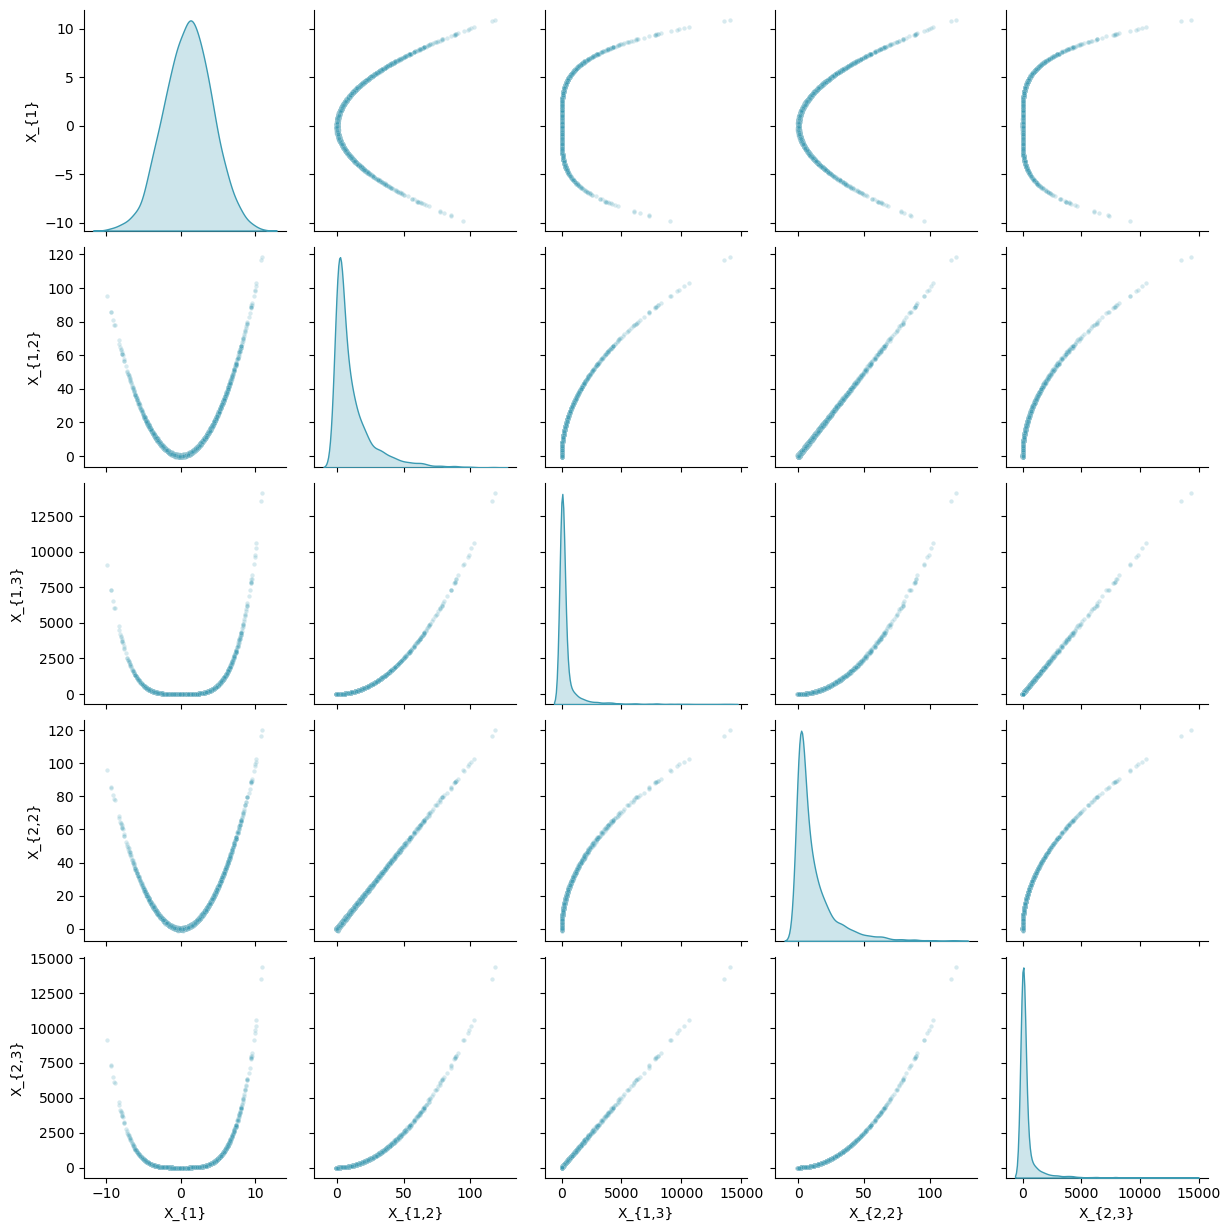

In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt

from utils import traceplot, acfplot, pairplot

# from rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock
from ipynb.fs.full.rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock

In [50]:
def project_to_psd(A):
    '''
    Project a matrix to the positive semidefinite cone.
    '''
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Set negative eigenvalues to 1e-10 for numerical stability
    # eigenvalues = np.maximum(eigenvalues, 1e-10)
    eigenvalues = np.abs(eigenvalues)

    # Reconstruct the matrix
    A_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    return A_psd


def is_psd(A, tol=1e-8):
    A = (A + A.T) / 2
    
    eigenvalues = np.linalg.eigvalsh(A)

    # Check if all eigenvalues are non-negative (within tolerance)
    return np.all(eigenvalues >= -tol)


# MCMC Algorithms


## Random Walk Metropolis


In [3]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Metropolis-Adjusted Langevin Algorithm


In [4]:
def MALA_proposal(x, partial_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * partial_logpi_x + z


def MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * partial_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * partial_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def MALA(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        
        # Proposal state
        y = MALA_proposal(x, partial_logpi_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Barker Metropolis-Hastings


In [5]:
def stable_log1p_exp(x):
    '''
    Compute log(1 + exp(x)) using the log-sum-exp trick for numerical stability.
    '''
    # return np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x)))

    # For large positive x, exp(-x) -> 0, so directly return x
    return np.where(x > 700, x, np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x))))


def Barker_proposal(x, partial_logpi_x, step_size):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * partial_logpi_x))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y):
    z = y - x

    logq_xy = - np.log1p(np.exp(- z * partial_logpi_x))
    logq_yx = - np.log1p(np.exp(z * partial_logpi_y))

    # logq_xy = -stable_log1p_exp(-z * partial_logpi_x)
    # logq_yx = -stable_log1p_exp(z * partial_logpi_y)

    return np.sum(logq_yx - logq_xy)
   

def Barker(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)

        # Proposal state
        y = Barker_proposal(x, partial_logpi_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log Barker acceptance rate
        log_acceptance = logpi_y - logpi_x + Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y)
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted +=1

        X[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate 

## Simplified Manifold Metropolis-Adjusted Langevin Algorithm


SMMALA acceptance rate: 0.6976


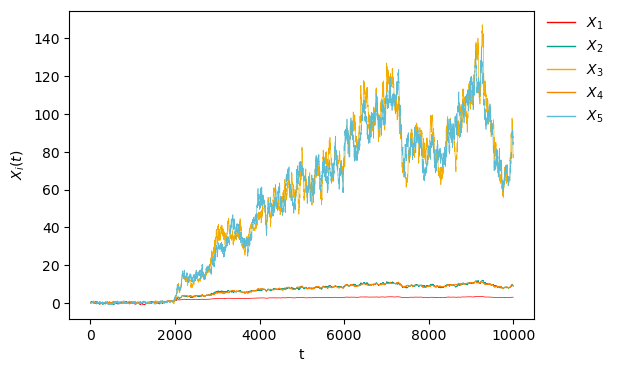

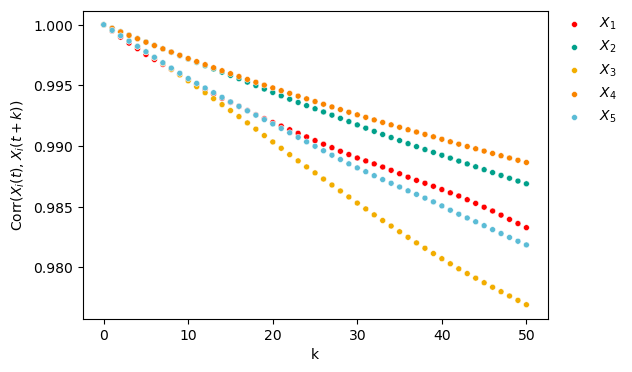

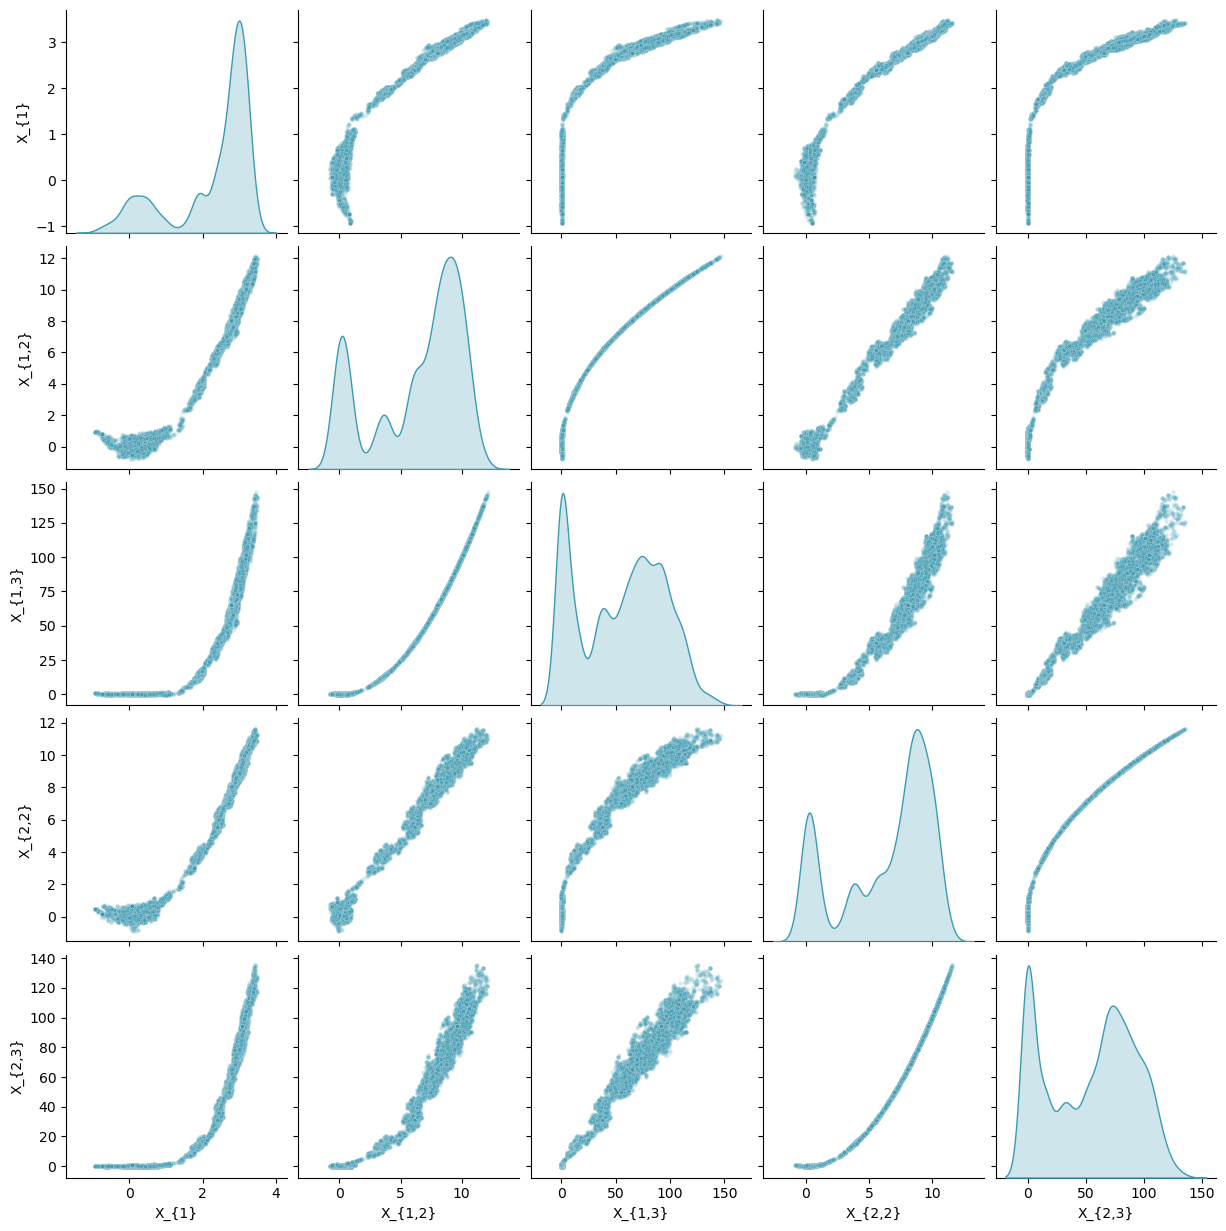

In [55]:
def SMMALA_proposal(x, partial_logpi_x, A_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) 

    L_x = np.linalg.cholesky(project_to_psd(A_x))

    return x + (1/2) * (step_size**2) * A_x @ partial_logpi_x + L_x @ z


def SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size):
    mean_xy = x + (1/2) * (step_size**2) * A_x @ partial_logpi_x
    mean_yx = y + (1/2) * (step_size**2) * A_y @ partial_logpi_y

    cov_xy = (step_size**2) * A_x
    cov_yx = (step_size**2) * A_y

    try:
        log_xy = multivariate_normal.logpdf(y, mean=mean_xy, cov=project_to_psd(cov_xy))
        log_yx = multivariate_normal.logpdf(x, mean=mean_yx, cov=project_to_psd(cov_yx))
    except:
        print('x', x)
        print('A_x', A_x, np.linalg.det(A_x))
        print('PSD A_x', project_to_psd(A_x), np.linalg.det(project_to_psd(A_x)), np.linalg.matrix_rank(project_to_psd(A_x)))
        print('y', y)
        print('A_y', A_y, np.linalg.det(A_y))
        print('PSD A_y', project_to_psd(A_y), np.linalg.det(project_to_psd(A_y)), np.linalg.inv(project_to_psd(A_y)), np.linalg.det(np.linalg.inv(project_to_psd(A_y))))
    
    return log_yx - log_xy


def SMMALA(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = np.linalg.inv(-H_x)

        # Proposal state
        y = SMMALA_proposal(x, partial_logpi_x, A_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = np.linalg.inv(-H_y)

        # Log SMMALA acceptance rate
        log_acceptance = logpi_y - logpi_x + SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate


N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 10000

X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.2273,
    n1=N1,
    n2=N2
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)

acfplot(X_smmala)

pairplot(X_smmala, N1, N2)

## Simplified Manifold Barker Metropolis-Hastings


In [56]:
def SMBarker_proposal(x, partial_logpi_x, L_x, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * (partial_logpi_x @ L_x)))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + L_x @ (b * z)


def SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y):
    z_xy = np.linalg.inv(L_x) @ (x - y)
    z_yx = np.linalg.inv(L_y) @ (y - x)

    logq_xy = - np.log1p(np.exp(z_xy @ (partial_logpi_x @ L_x)))
    logq_yx = - np.log1p(np.exp(z_yx @ (partial_logpi_y @ L_y)))

    return np.sum(logq_yx - logq_xy)


def SMBarker(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = project_to_psd(np.linalg.inv(-H_x))
        L_x = np.linalg.cholesky(A_x)

        # Propose candidate state
        y = SMBarker_proposal(x, partial_logpi_x, L_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = project_to_psd(np.linalg.inv(-H_y))
        L_y = np.linalg.cholesky(A_y)

        # Log SMBarker acceptance rate
        log_acceptance = logpi_y - logpi_x + SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate


# Experiment


Standard parametrization:

-   $\mu = 1$
-   $a  = 1/20$
-   $b_{i, j} = 100/20 \quad (\forall i, j)$


## 2D Rosenbrock


RWM acceptance rate: 0.2579


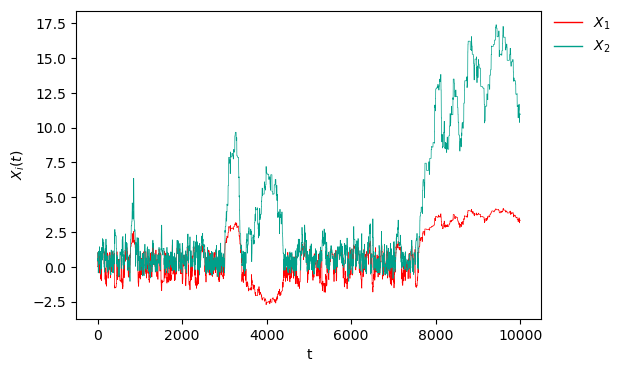

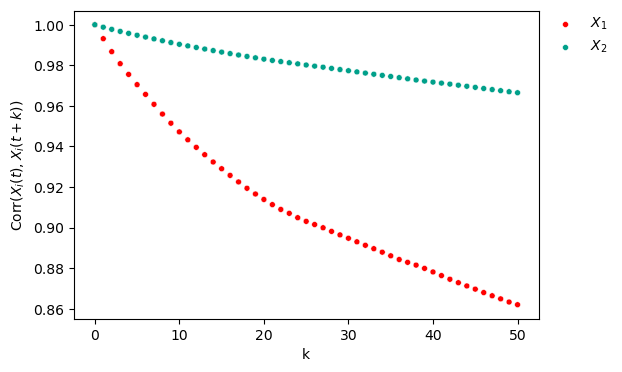

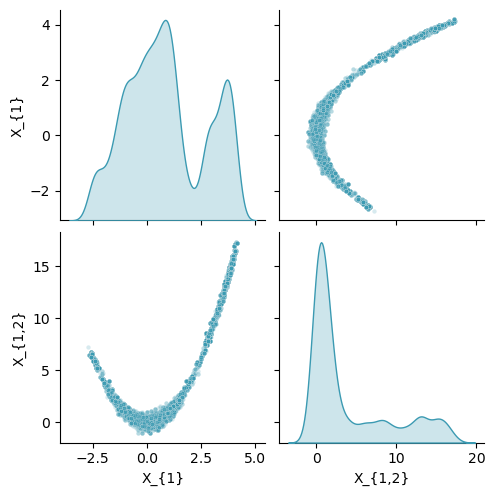

In [8]:
N1 = 2
N2 = 1
X_INIT = [0, 1]
N_ITER = 10000

X_rwm, accept_rate = RWM(
    logpi=logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.6,
    n1=N1,
    n2=N2
)

print(f'RWM acceptance rate: {accept_rate}')
traceplot(X_rwm)
acfplot(X_rwm)
pairplot(X_rwm, N1, N2)

Barker acceptance rate: 0.5356


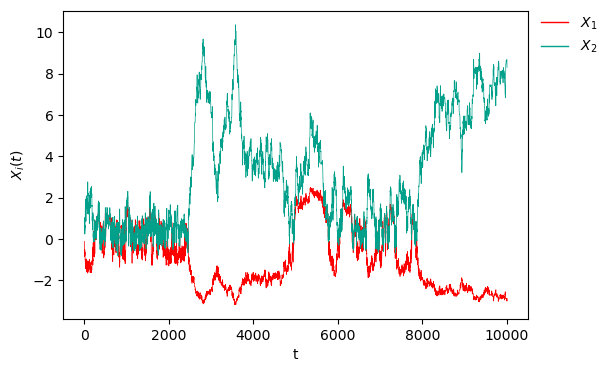

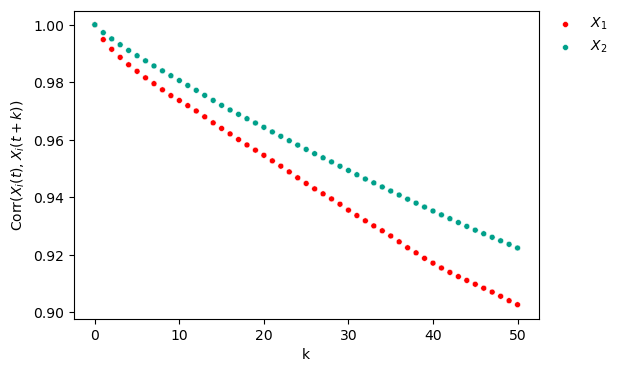

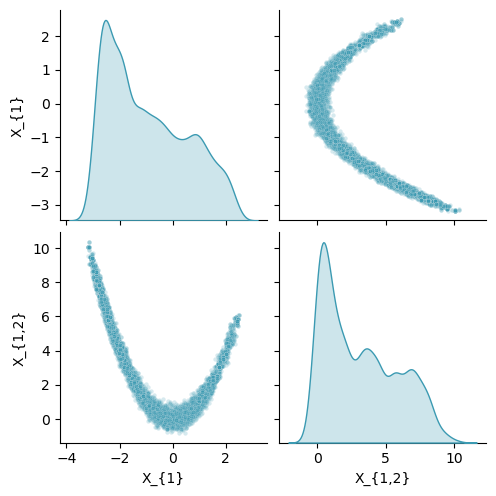

In [9]:
X_barker, accept_rate = Barker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.3,
    n1=N1,
    n2=N2
)

print(f'Barker acceptance rate: {accept_rate}')
traceplot(X_barker)
acfplot(X_barker)
pairplot(X_barker, N1, N2)

MALA acceptance rate: 0.4796


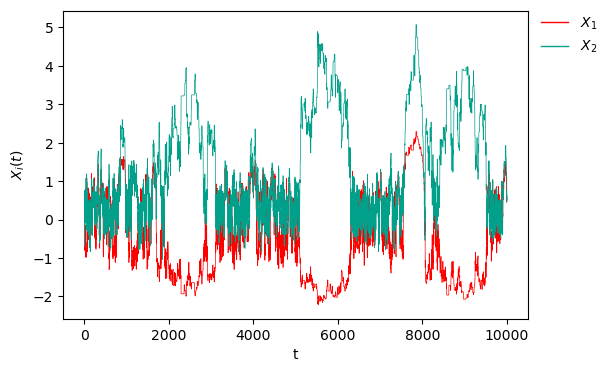

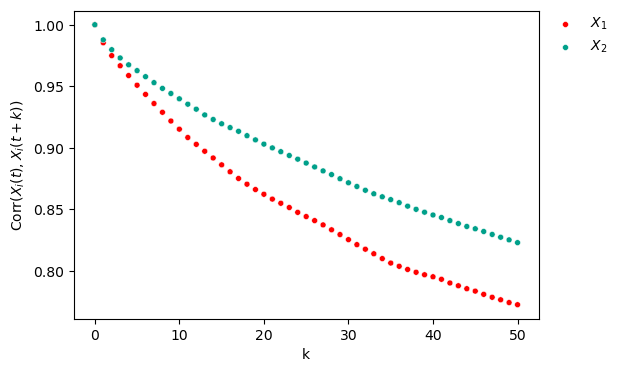

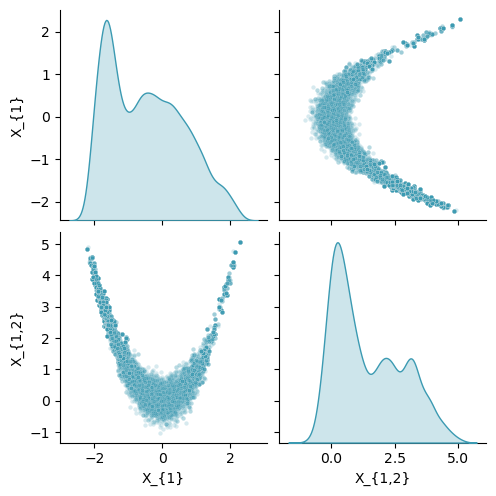

In [10]:
X_mala, accept_rate = MALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.3,
    n1=N1,
    n2=N2
)

print(f'MALA acceptance rate: {accept_rate}')
traceplot(X_mala)
acfplot(X_mala)
pairplot(X_mala, N1, N2)

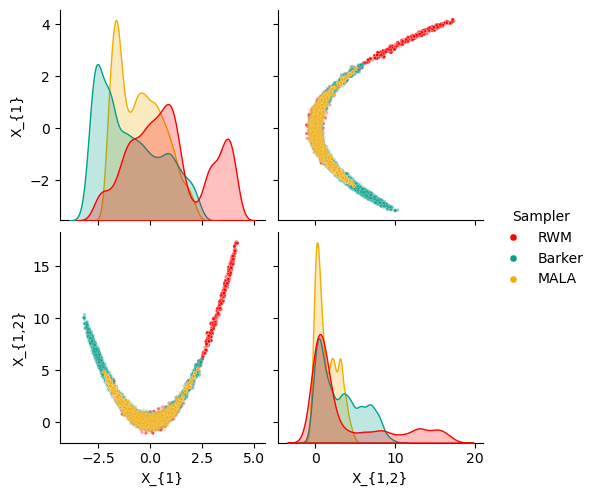

In [62]:
pairplot([X_rwm, X_barker, X_mala], sampler_names=['RWM', 'Barker', 'MALA'], n1=2, n2=1)

SMBarker acceptance rate: 0.6291


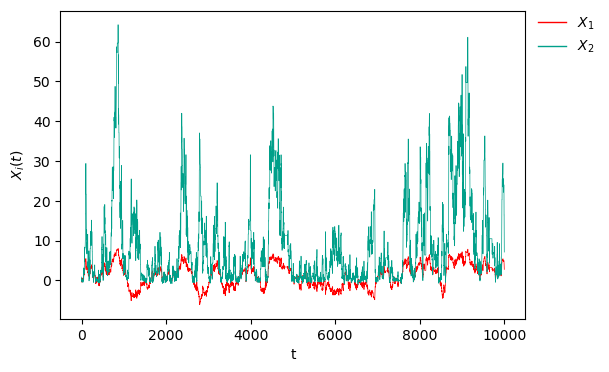

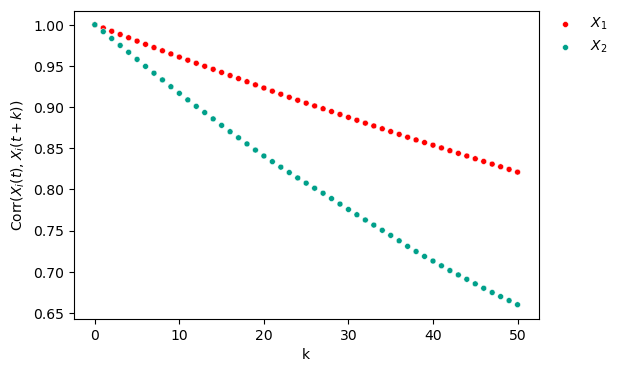

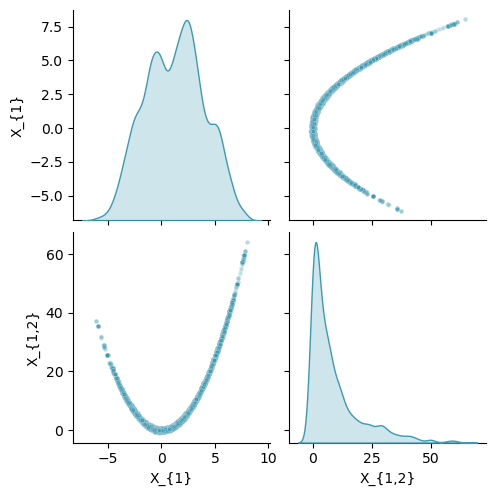

In [11]:
X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=1.3,
    n1=N1,
    n2=N2
)

print(f'SMBarker acceptance rate: {accept_rate}')
traceplot(X_smbarker)
acfplot(X_smbarker)
pairplot(X_smbarker, N1, N2)

In [27]:
X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=1.2,
    n1=N1,
    n2=N2
)

print(f'SMMALA acceptance rate: {accept_rate}')
traceplot(X_smmala)
acfplot(X_smmala)
pairplot(X_smmala, N1, N2)

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

## 3D Rosenbrock


SMMALA acceptance rate: 0.5902


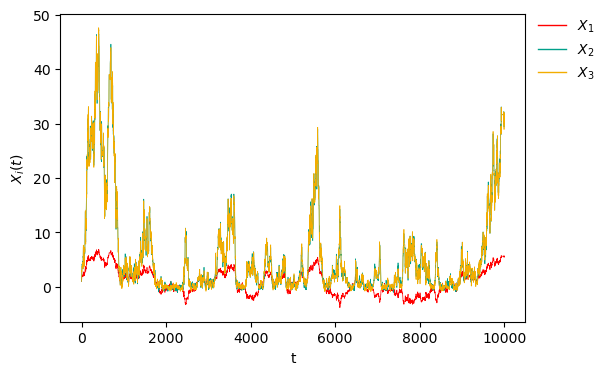

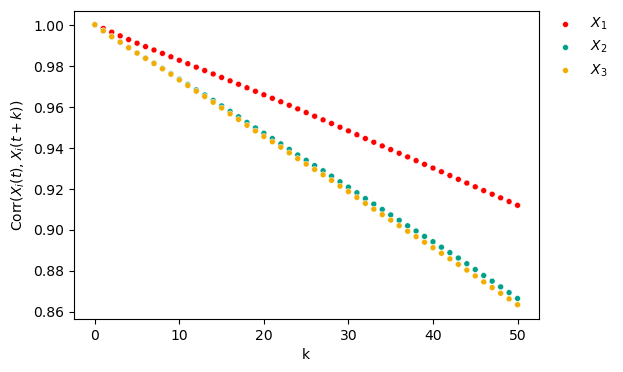

SMBarker acceptance rate: 0.5871


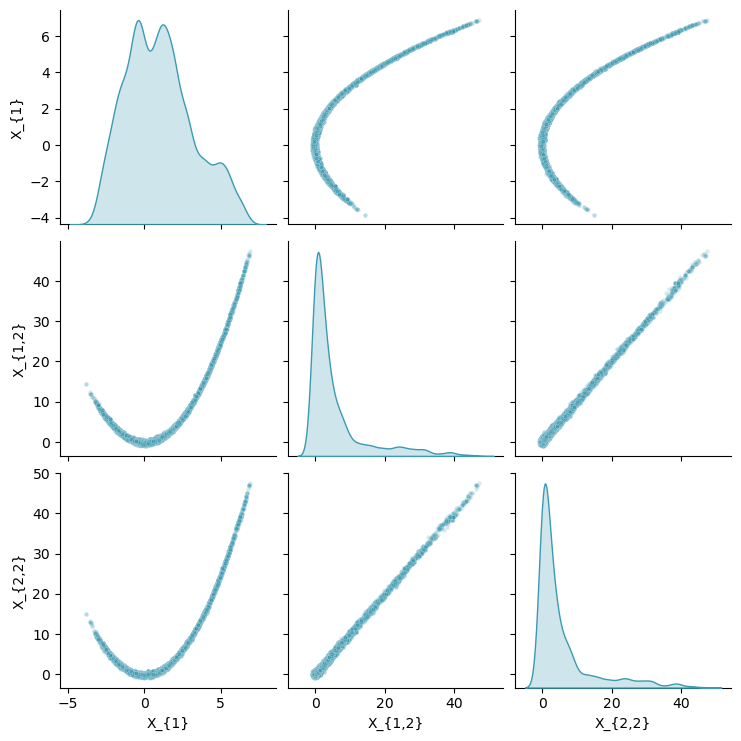

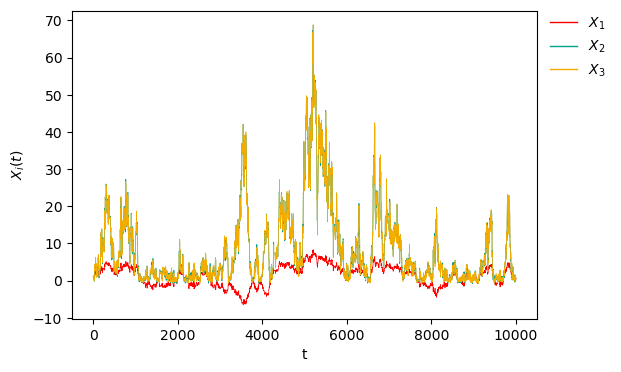

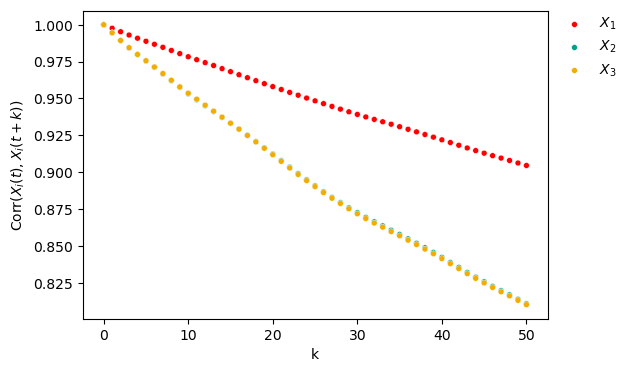

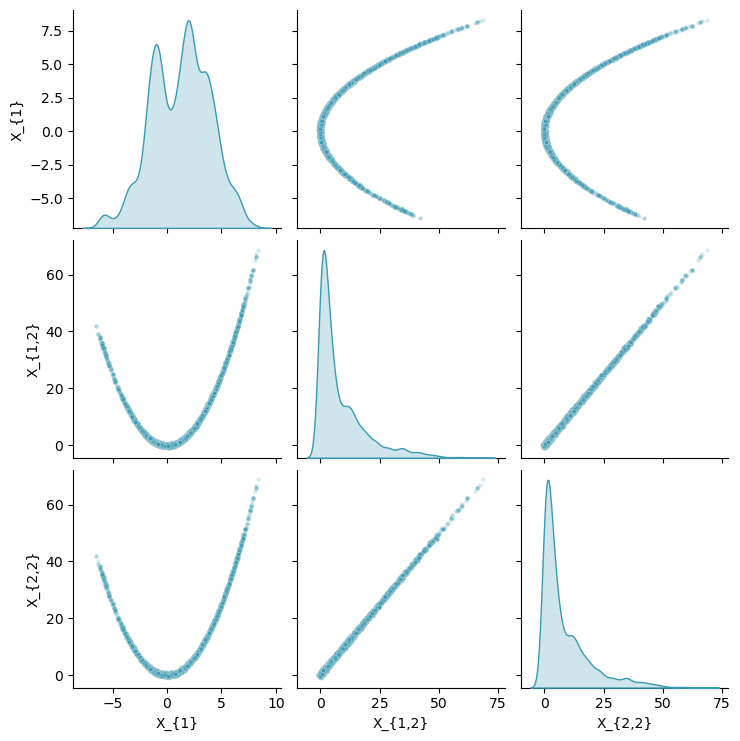

In [13]:
N1 = 2
N2 = 2
X_INIT = [1, 1, 1]
N_ITER = 10000

X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.59,
    n1=N1,
    n2=N2
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)
acfplot(X_smmala)
pairplot(X_smmala, N1, N2)

X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=1.15,
    n1=N1,
    n2=N2
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_smbarker)
acfplot(X_smbarker)
pairplot(X_smbarker, N1, N2)

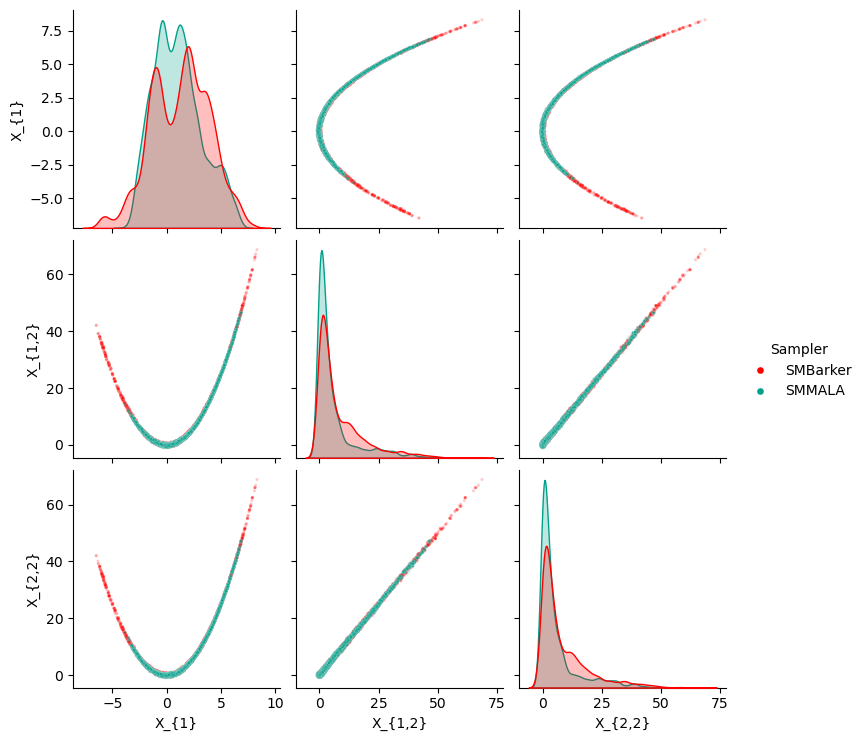

In [14]:
pairplot([X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['SMBarker', 'SMMALA'])

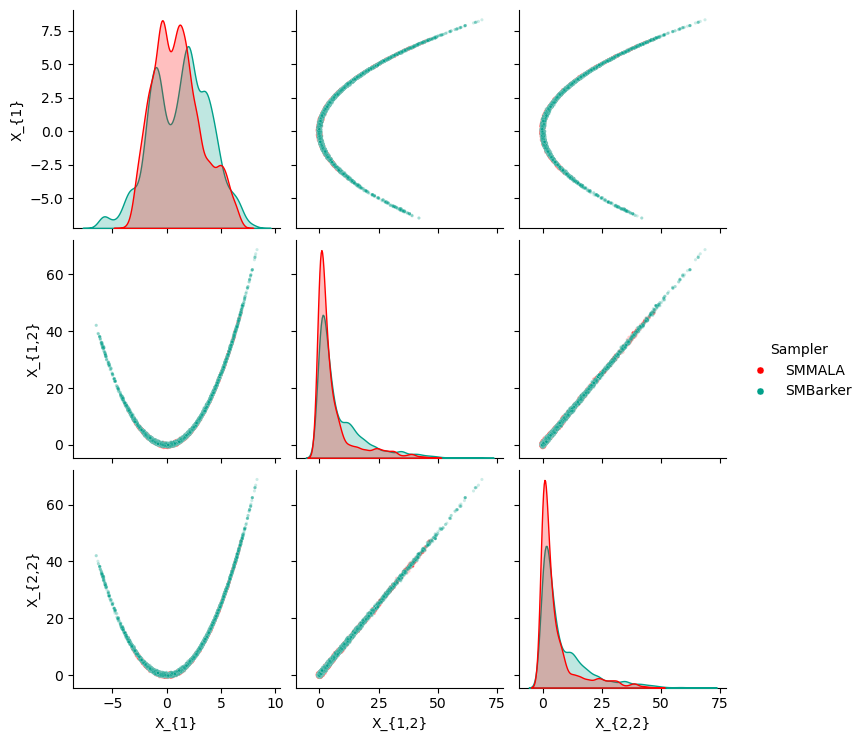

In [15]:

pairplot([X_smmala, X_smbarker], n1=N1, n2=N2, sampler_names=['SMMALA', 'SMBarker'])

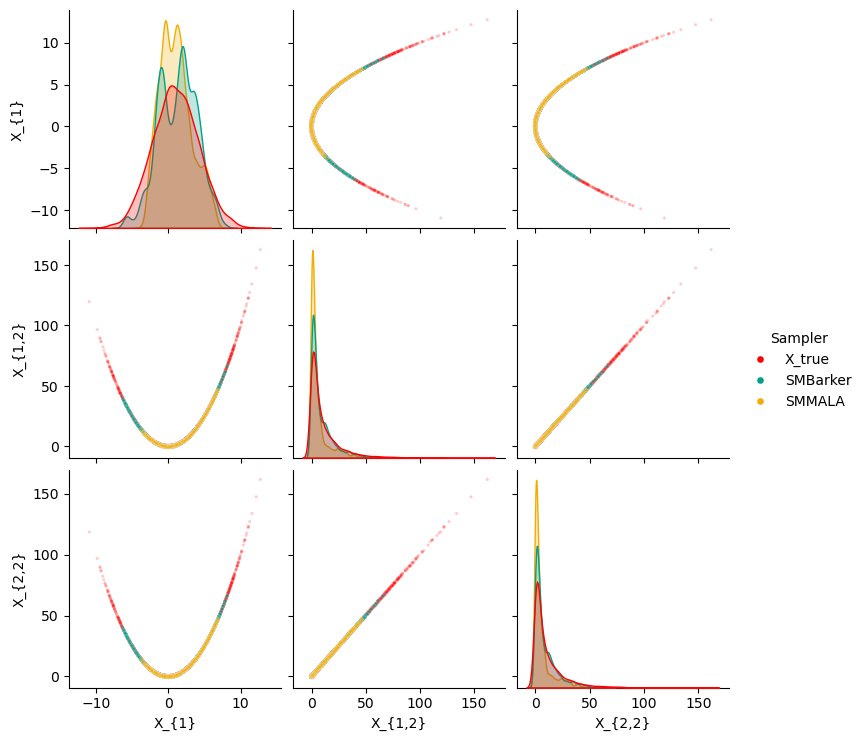

In [16]:
X_true = sample_rosenbrock(n_iter=N_ITER, n1=N1, n2=N2)

pairplot([X_true, X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['X_true', 'SMBarker', 'SMMALA'])

## 5D Rosenbrock


SMBarker acceptance rate: 0.5018


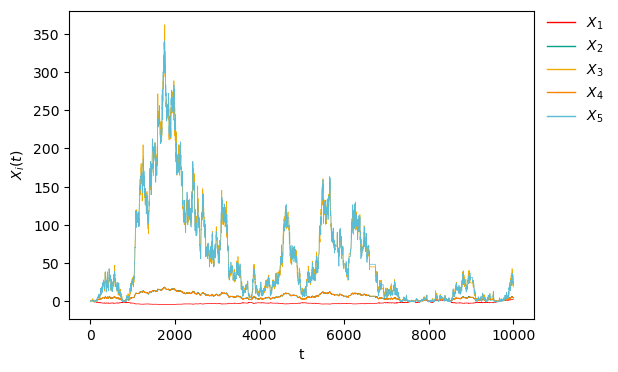

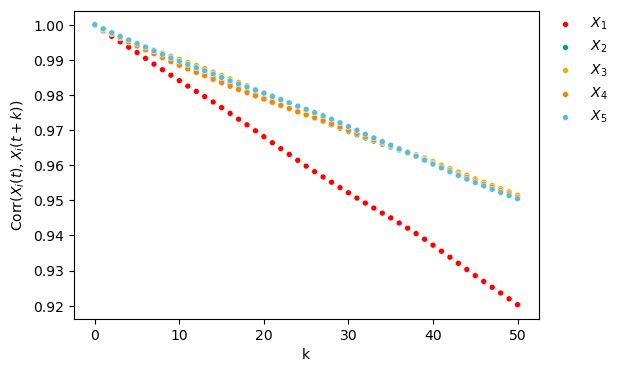

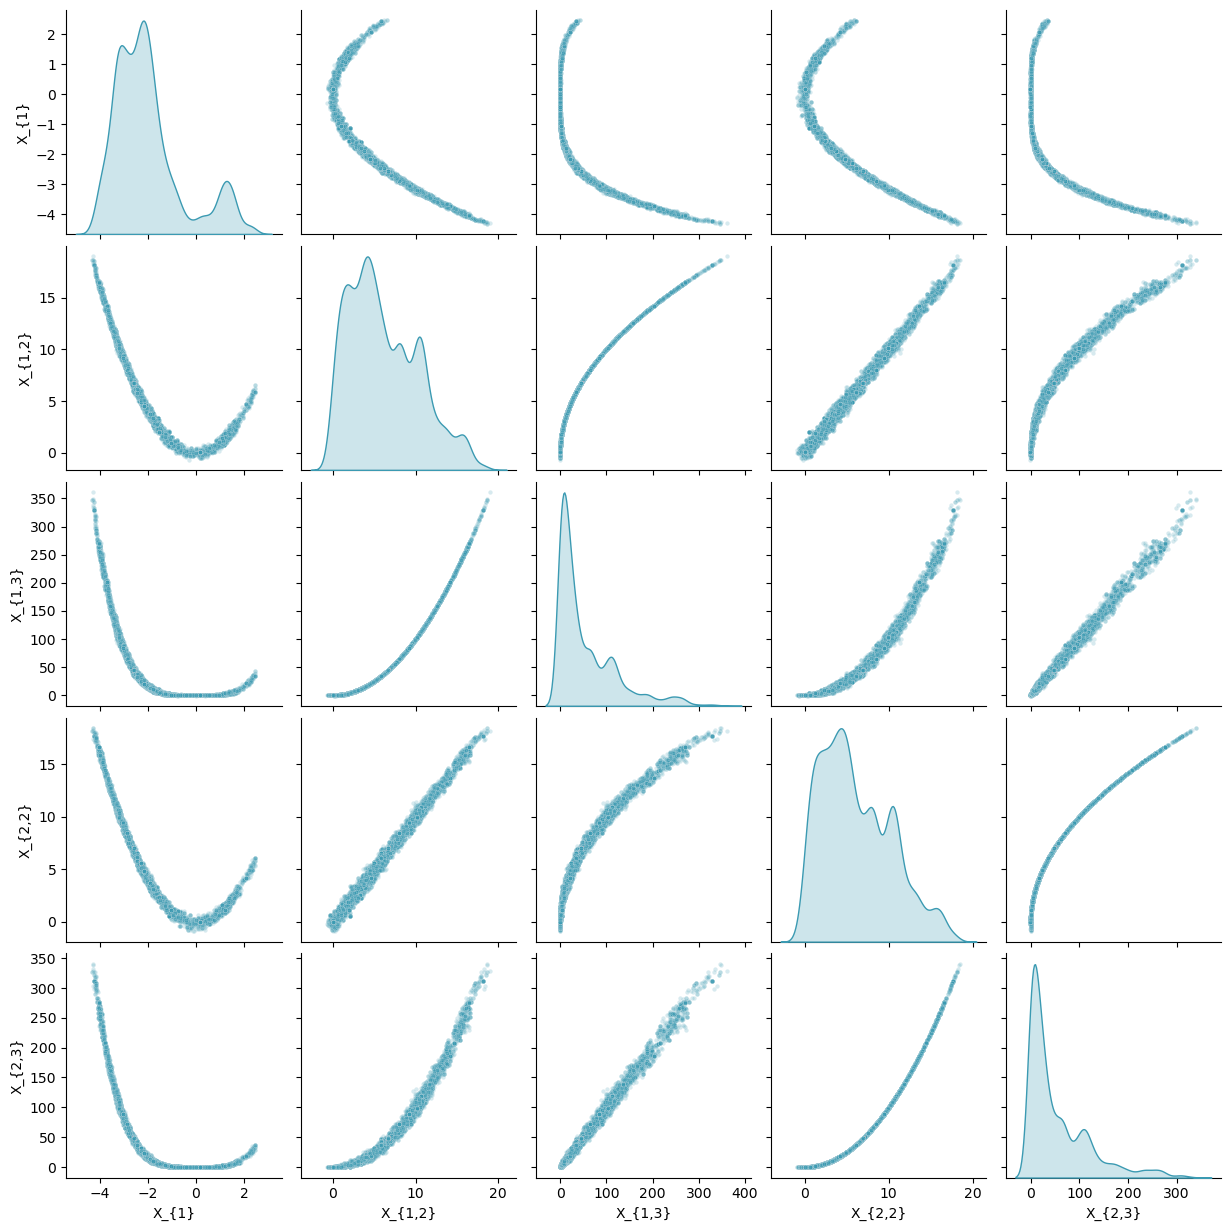

In [57]:
N1 = 3
N2 = 2
X_INIT = [0.1, 0.1, 0.1, 0.1, 0.1]
N_ITER = 10000

X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.85,
    n1=N1,
    n2=N2
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_smbarker)

acfplot(X_smbarker)

pairplot(X_smbarker, N1, N2)

SMMALA acceptance rate: 0.658


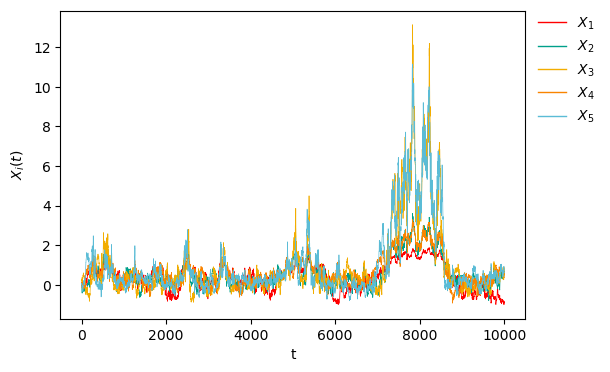

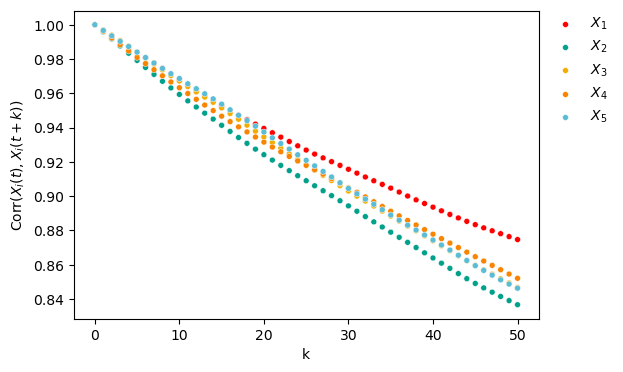

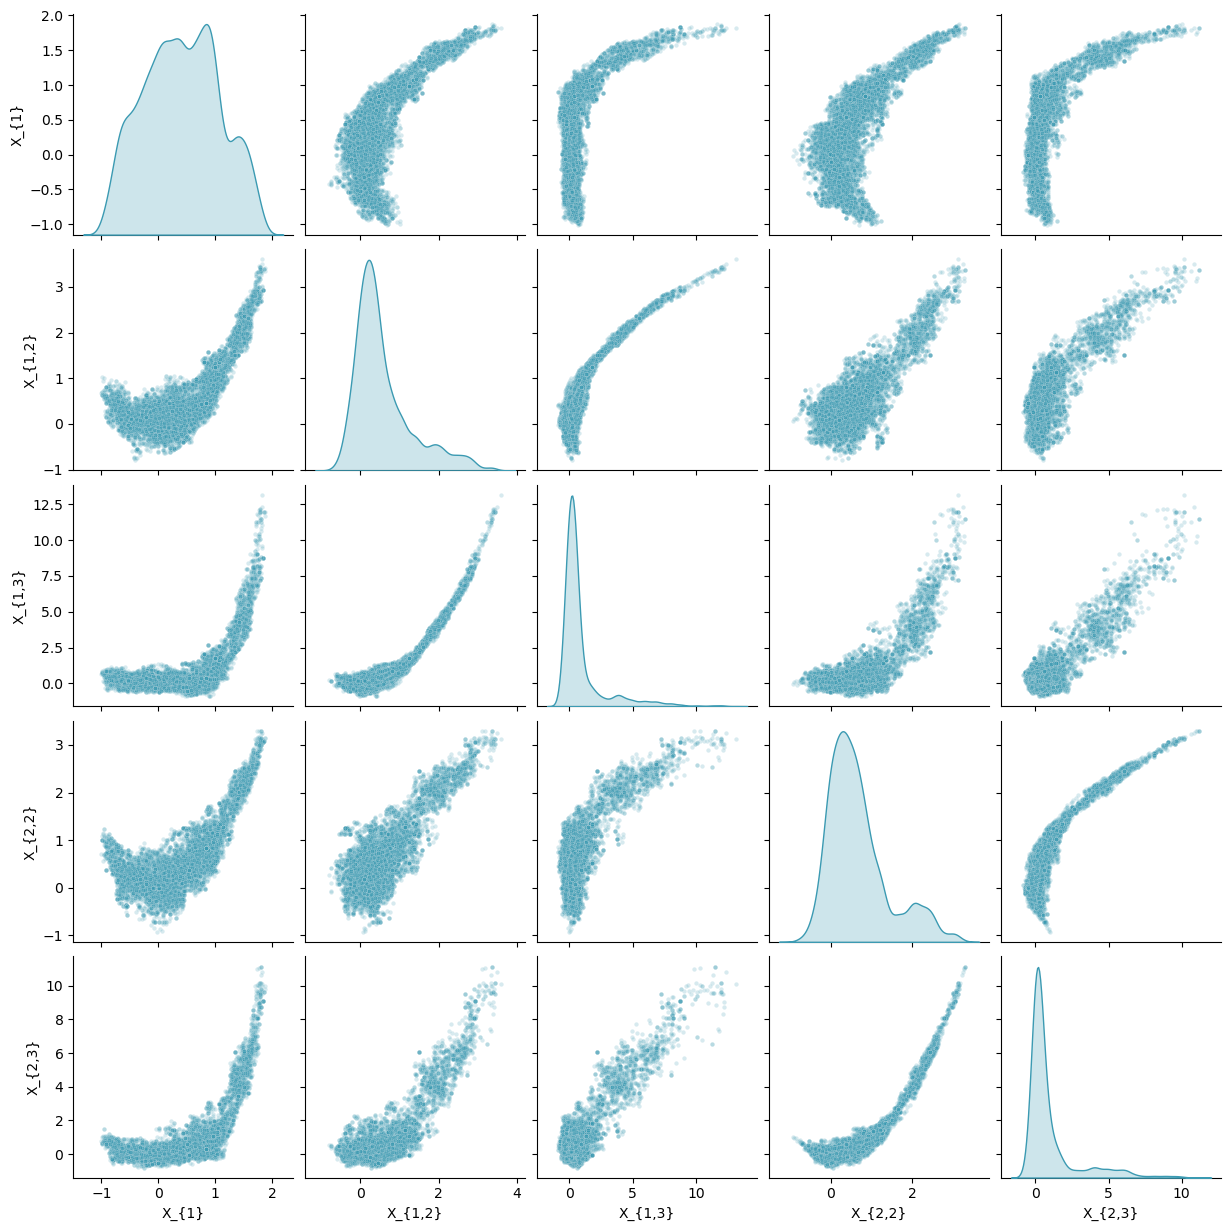

In [58]:
N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 10000

X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.2273,
    n1=N1,
    n2=N2
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)

acfplot(X_smmala)

pairplot(X_smmala, N1, N2)

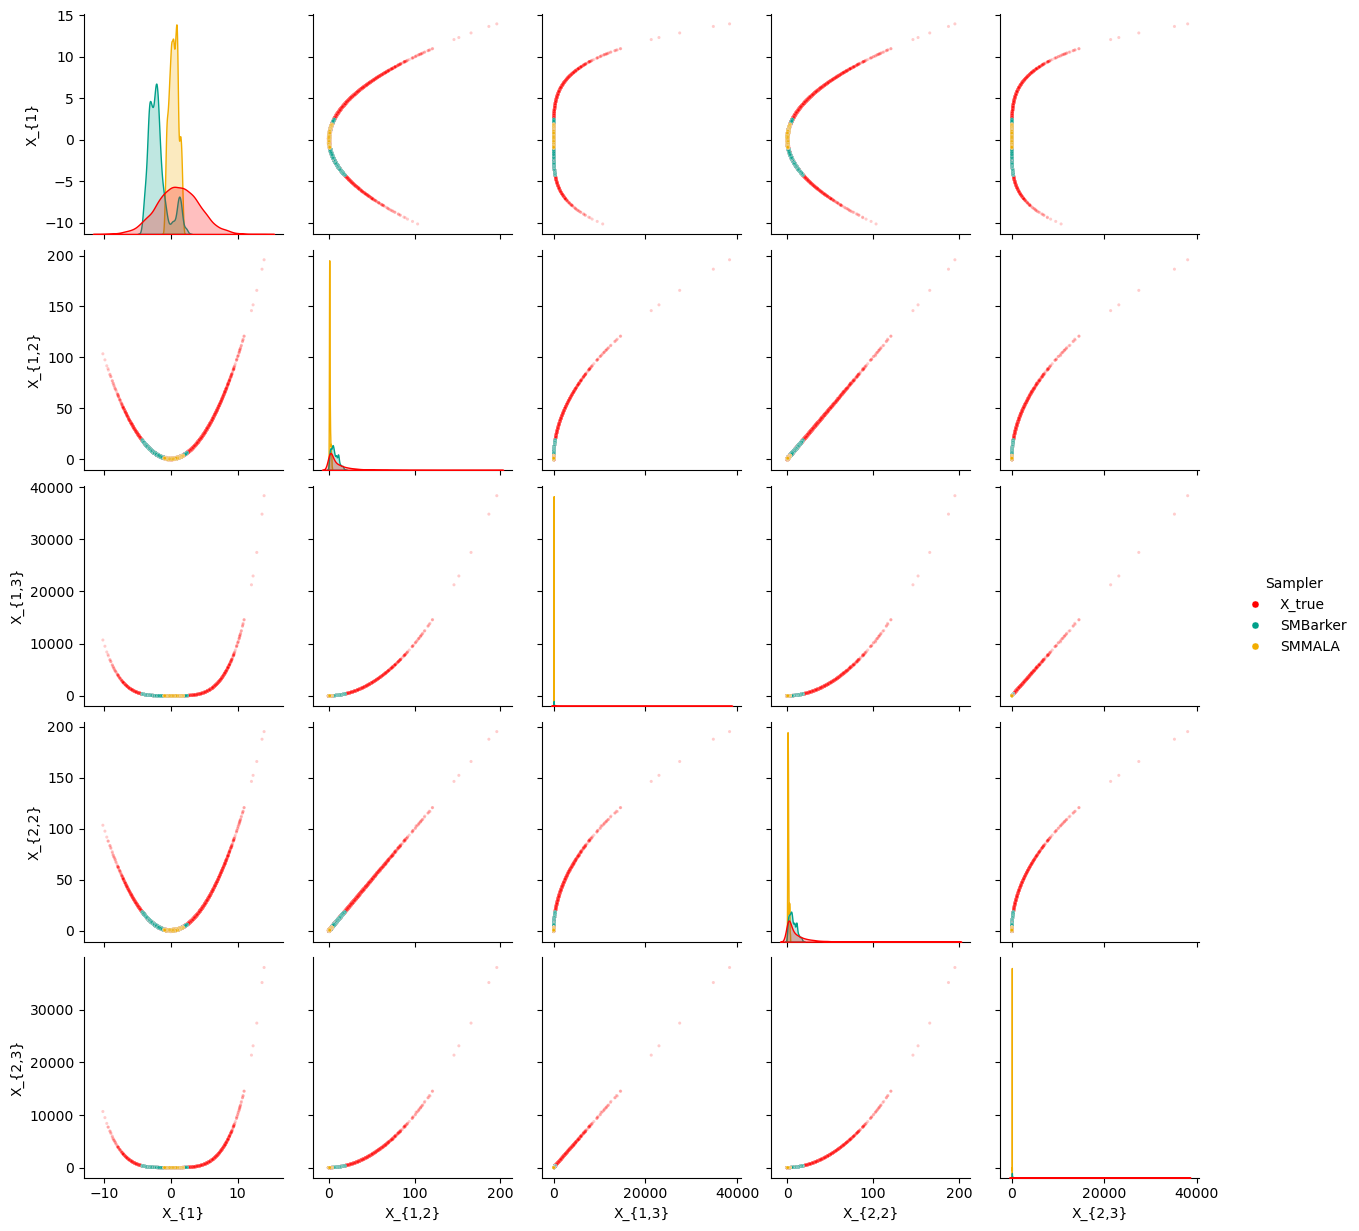

In [59]:
X_true = sample_rosenbrock(n_iter=N_ITER, n1=N1, n2=N2)

pairplot([X_true, X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['X_true', 'SMBarker', 'SMMALA'])